## Импорт библиотек и данных

Будем использовать numpy и pandas для работы с данными, matplotlib и seaborn для отрисовки графиков, из scipy достанем методы для корреляции, а также в statsmodels лежат необходимые методы для FA

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.multivariate.factor import Factor
from functools import reduce
import warnings
warnings.filterwarnings("ignore")

## Импорт предсказываемых факторов

Достаём данные с FRED, опубликованные в период 1979-01-01 — 2024-01-01

In [2]:
from pandas_datareader.data import DataReader
start = '1979-01-01'
end = '2024-01-01'
array, names = [], []

In [3]:
# Функция, которая агрегирует данные по квартилям (по последнему доступному значению) и записывает данные и их названия в соответствующие массивы
def data(df, name, array, names):
    df = df.resample('Q').last()
    df.index = df.index.to_period('Q').to_timestamp()
    array.append(df)
    names.append(name)
    return df, array, names

1. Банковские кредиты

In [4]:
TOTBKCR, array, names = data(DataReader('TOTBKCR', 'fred', start=start, end=end), 'BankCredit', array, names)

2. Депозиты

In [5]:
DPSACBW027SBOG, array, names = data(DataReader('DPSACBW027SBOG', 'fred', start=start, end=end), 'Deposits', array, names)

3. Кредиты на недвижимость

In [6]:
RELACBW027SBOG, array, names = data(DataReader('RELACBW027SBOG', 'fred', start=start, end=end), 'RealEstateLoans', array, names)

## Визуализация тенденций банковских продуктов

In [7]:
x = TOTBKCR.index
y1 = TOTBKCR['TOTBKCR'].to_numpy()
y2 = DPSACBW027SBOG['DPSACBW027SBOG'].to_numpy()
y3 = RELACBW027SBOG['RELACBW027SBOG'].to_numpy()

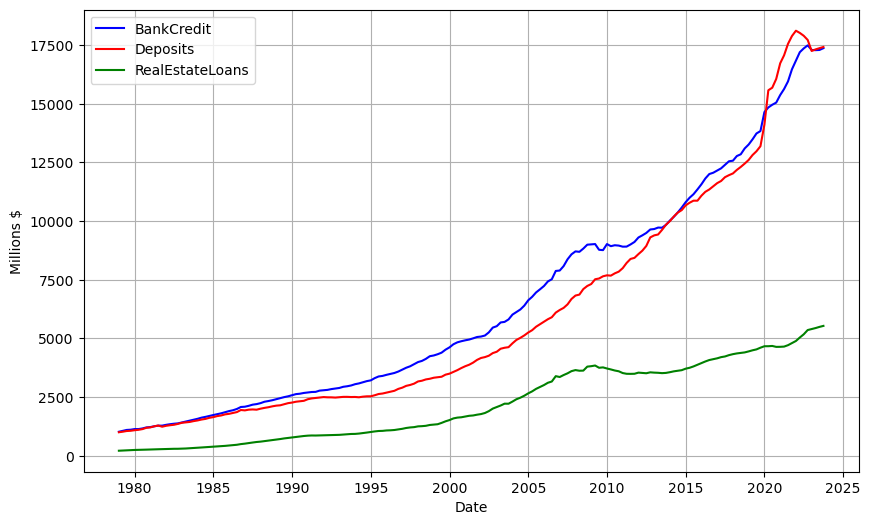

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='BankCredit', color='blue')
plt.plot(x, y2, label='Deposits', color='red')
plt.plot(x, y3, label='RealEstateLoans', color='green')
plt.xlabel('Date')
plt.ylabel('Millions $')
plt.grid()
plt.legend()
plt.show()

## Импорт предполагаемых макроэкономических переменных

По аналогии достаём данные с FRED, опубликованные в период 1979-01-01 — 2024-01-01

In [9]:
start = '1979-01-01'
end = '2023-12-01'
variable_names = []
not_diff = []

1. Эффективная ставка по федеральным фондам

In [10]:
FEDFUNDS, array, variable_names = data(DataReader('FEDFUNDS', 'fred', start=start, end=end), 'FederalFundsEffectiveRate', array, variable_names)
not_diff.append('FederalFundsEffectiveRate')

2. Денежная база

In [11]:
BOGMBASE, array, variable_names = data(DataReader('BOGMBASE', 'fred', start=start, end=end), 'MonetaryBase', array, variable_names)

3. Реальный располагаемый личный доход

In [12]:
DSPIC96, array, variable_names = data(DataReader('DSPIC96', 'fred', start=start, end=end), 'RealDisposablePersonalIncome', array, variable_names)

4. Валовой внутренний продукт

In [13]:
GDP, array, variable_names = data(DataReader('GDP', 'fred', start=start, end=end), 'GrossDomesticProduct', array, variable_names)

5. Уровень безработицы

In [14]:
UNRATE, array, variable_names = data(DataReader('UNRATE', 'fred', start=start, end=end), 'UnemploymentRate', array, variable_names)
not_diff.append('UnemploymentRate')

6. Спотовая цена на сырую нефть

In [15]:
WTISPLC, array, variable_names = data(DataReader('WTISPLC', 'fred', start=start, end=end), 'SpotCrudeOilPrice', array, variable_names)

7. Cредняя стоимость аренды основного жилья

In [16]:
CUSR0000SEHA, array, variable_names = data(DataReader('CUSR0000SEHA', 'fred', start=start, end=end), 'RentOfPrimaryResidence', array, variable_names)

8. Индекс цен на коммерческую недвижимость

In [17]:
BOGZ1FL075035503Q, array, variable_names = data(DataReader('BOGZ1FL075035503Q', 'fred', start=start, end=end), 'CommercialRealEstatePriceIndex', array, variable_names)
not_diff.append('CommercialRealEstatePriceIndex')

9.  Изменения базовой процентной ставки по кредитам

In [18]:
DPRIME, array, variable_names = data(DataReader('DPRIME', 'fred', start=start, end=end), 'BankPrimeLoanRateChanges', array, variable_names)
not_diff.append('BankPrimeLoanRateChanges')

10. Коэффициент вакантных площадей

In [19]:
RRVRUSQ156N, array, variable_names = data(DataReader('RRVRUSQ156N', 'fred', start=start, end=end), 'RentalVacancyRate', array, variable_names)
not_diff.append('RentalVacancyRate')

11. Корпоративная прибыль до налогообложения

In [20]:
A053RC1Q027SBEA, array, variable_names = data(DataReader('A053RC1Q027SBEA', 'fred', start=start, end=end), 'CorporateProfitsBeforeTax', array, variable_names)

12. Совпадающий индекс экономической активности

In [21]:
USPHCI, array, variable_names = data(DataReader('USPHCI', 'fred', start=start, end=end), 'CoincidentEconomicActivityIndex', array, variable_names)
not_diff.append('CoincidentEconomicActivityIndex')

13. Средняя цена продажи домов

In [22]:
MSPUS, array, variable_names = data(DataReader('MSPUS', 'fred', start=start, end=end), 'MedianSalesPriceofHousesSold', array, variable_names)

14. Рыночная доходность казначейских ценных бумаг США

In [23]:
DGS5, array, variable_names = data(DataReader('DGS5', 'fred', start=start, end=end), 'MarketYieldOnTreasurySecurities', array, variable_names)
not_diff.append('MarketYieldOnTreasurySecurities')

15. Процентные ставки по депозитам

In [24]:
IR3TCD01USM156N, array, variable_names = data(DataReader('IR3TCD01USM156N', 'fred', start=start, end=end), 'InterestRatesOfDeposit', array, variable_names)
not_diff.append('InterestRatesOfDeposit')

16. Ставка личных сбережений

In [25]:
PSAVERT, array, variable_names = data(DataReader('PSAVERT', 'fred', start=start, end=end), 'PersonalSavingRate', array, variable_names)
not_diff.append('PersonalSavingRate')

17. Индекс потребительских цен

In [26]:
CORESTICKM159SFRBATL, array, variable_names = data(DataReader('CORESTICKM159SFRBATL', 'fred', start=start, end=end), 'StickyPriceConsumer', array, variable_names)
not_diff.append('StickyPriceConsumer')

18. Фича = разности DPRIME(9) и FEDFUNDS (1)

In [27]:
combined_data = pd.merge(FEDFUNDS, DPRIME, left_index=True, right_index=True, how='inner')
combined_data['RateDifference'] = combined_data['DPRIME'] - combined_data['FEDFUNDS']
RateDifference = combined_data['RateDifference']
variable_names.append('RateDifference')
array.append(RateDifference)
not_diff.append('RateDifference')

In [28]:
# В not_diff будут храниться макроэкономические переменные, которые интересно рассматривать не только как разности, но и в оригинальном виде
not_diff = set(not_diff)

## Создание датасета со всеми макроэкономическими переменными и факторами

In [29]:
dta = pd.concat(array, axis=1)
names = names + variable_names
dta.columns = names
dta.index.freq = dta.index.inferred_freq
dta.sample()

BankCredit   Deposits  RealEstateLoans  FederalFundsEffectiveRate  \
DATE                                                                            
1997-10-01   3905.2897  3074.4254         1221.636                        5.5   

            MonetaryBase  RealDisposablePersonalIncome  GrossDomesticProduct  \
DATE                                                                           
1997-10-01         493.1                        8944.3              8765.907   

            UnemploymentRate  SpotCrudeOilPrice  RentOfPrimaryResidence  ...  \
DATE                                                                     ...   
1997-10-01               4.7              18.32                   169.0  ...   

            BankPrimeLoanRateChanges  RentalVacancyRate  \
DATE                                                      
1997-10-01                       8.5                7.7   

            CorporateProfitsBeforeTax  CoincidentEconomicActivityIndex  \
DATE                                                                     
1997-10-01                    836.112                            79.41   

            MedianSalesPriceofHousesSold  MarketYieldOnTreasurySecurities  \
DATE                                                                        
1997-10-01                        144200                             5.71   

            InterestRatesOfDeposit  PersonalSavingRate  StickyPriceConsumer  \
DATE                                                                          
1997-10-01                     5.8                 6.1             2.621536   

            RateDifference  
DATE                        
1997-10-01             3.0  

[1 rows x 21 columns]

## Визуализация тенденций макроэкономических переменных

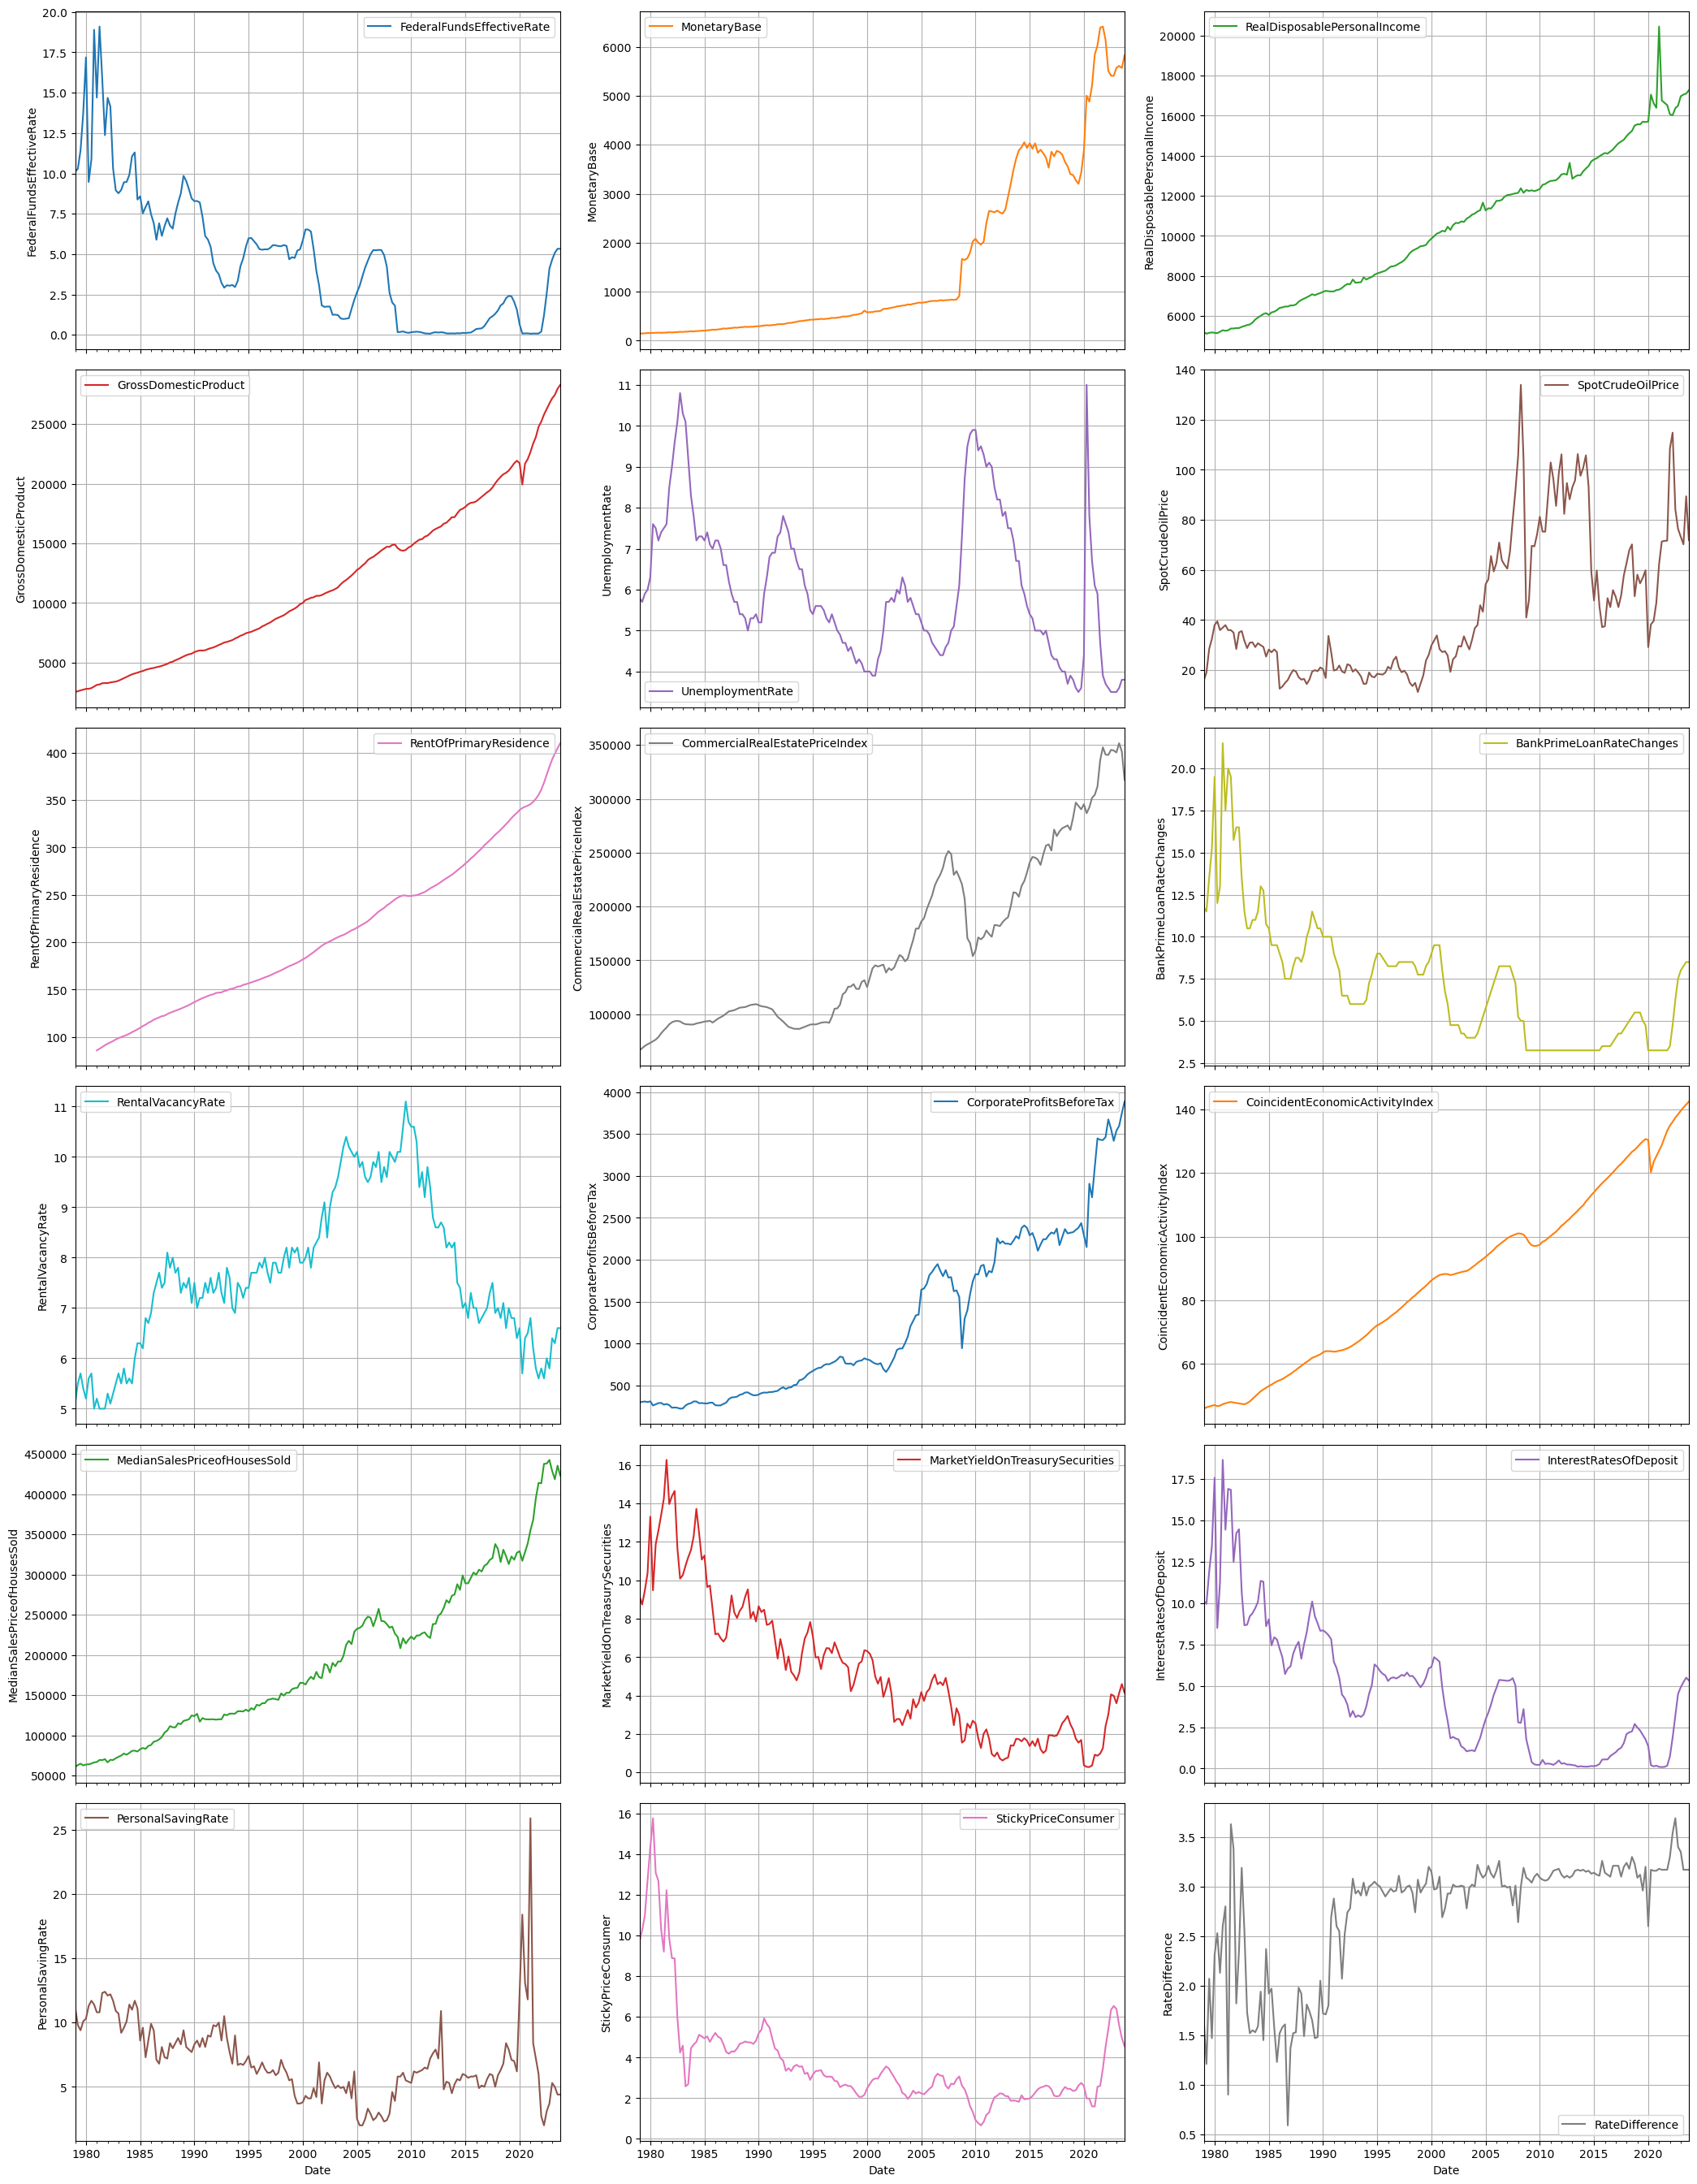

In [30]:
axes = dta[variable_names].plot(subplots=True, layout=(6, 3), figsize=(21, 27))
for i, ax in enumerate(axes.flatten()):
    if i < len(variable_names):
        ax.set_xlabel('Date')
        ax.set_ylabel(variable_names[i])
        ax.grid(True)
plt.tight_layout()
plt.show()

## Чистка макроэкономических переменных от выбросов

Выбросы считаем по правилу трёх сигма (всё, что больше, чем среднее + 3 стандартных отклонения, и меньше, чем среднее - 3 стандартных отклонения)

In [31]:
def outliers(df):
    for column in range(len(names)):
        mean = df[names[column]].mean()
        std = df[names[column]].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        df[names[column]] = df[names[column]].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
        df[names[column]] = df[names[column]].ffill()  
    return df

In [32]:
dta = outliers(dta)

## Визуализация тенденций очищенных макроэкономических переменных

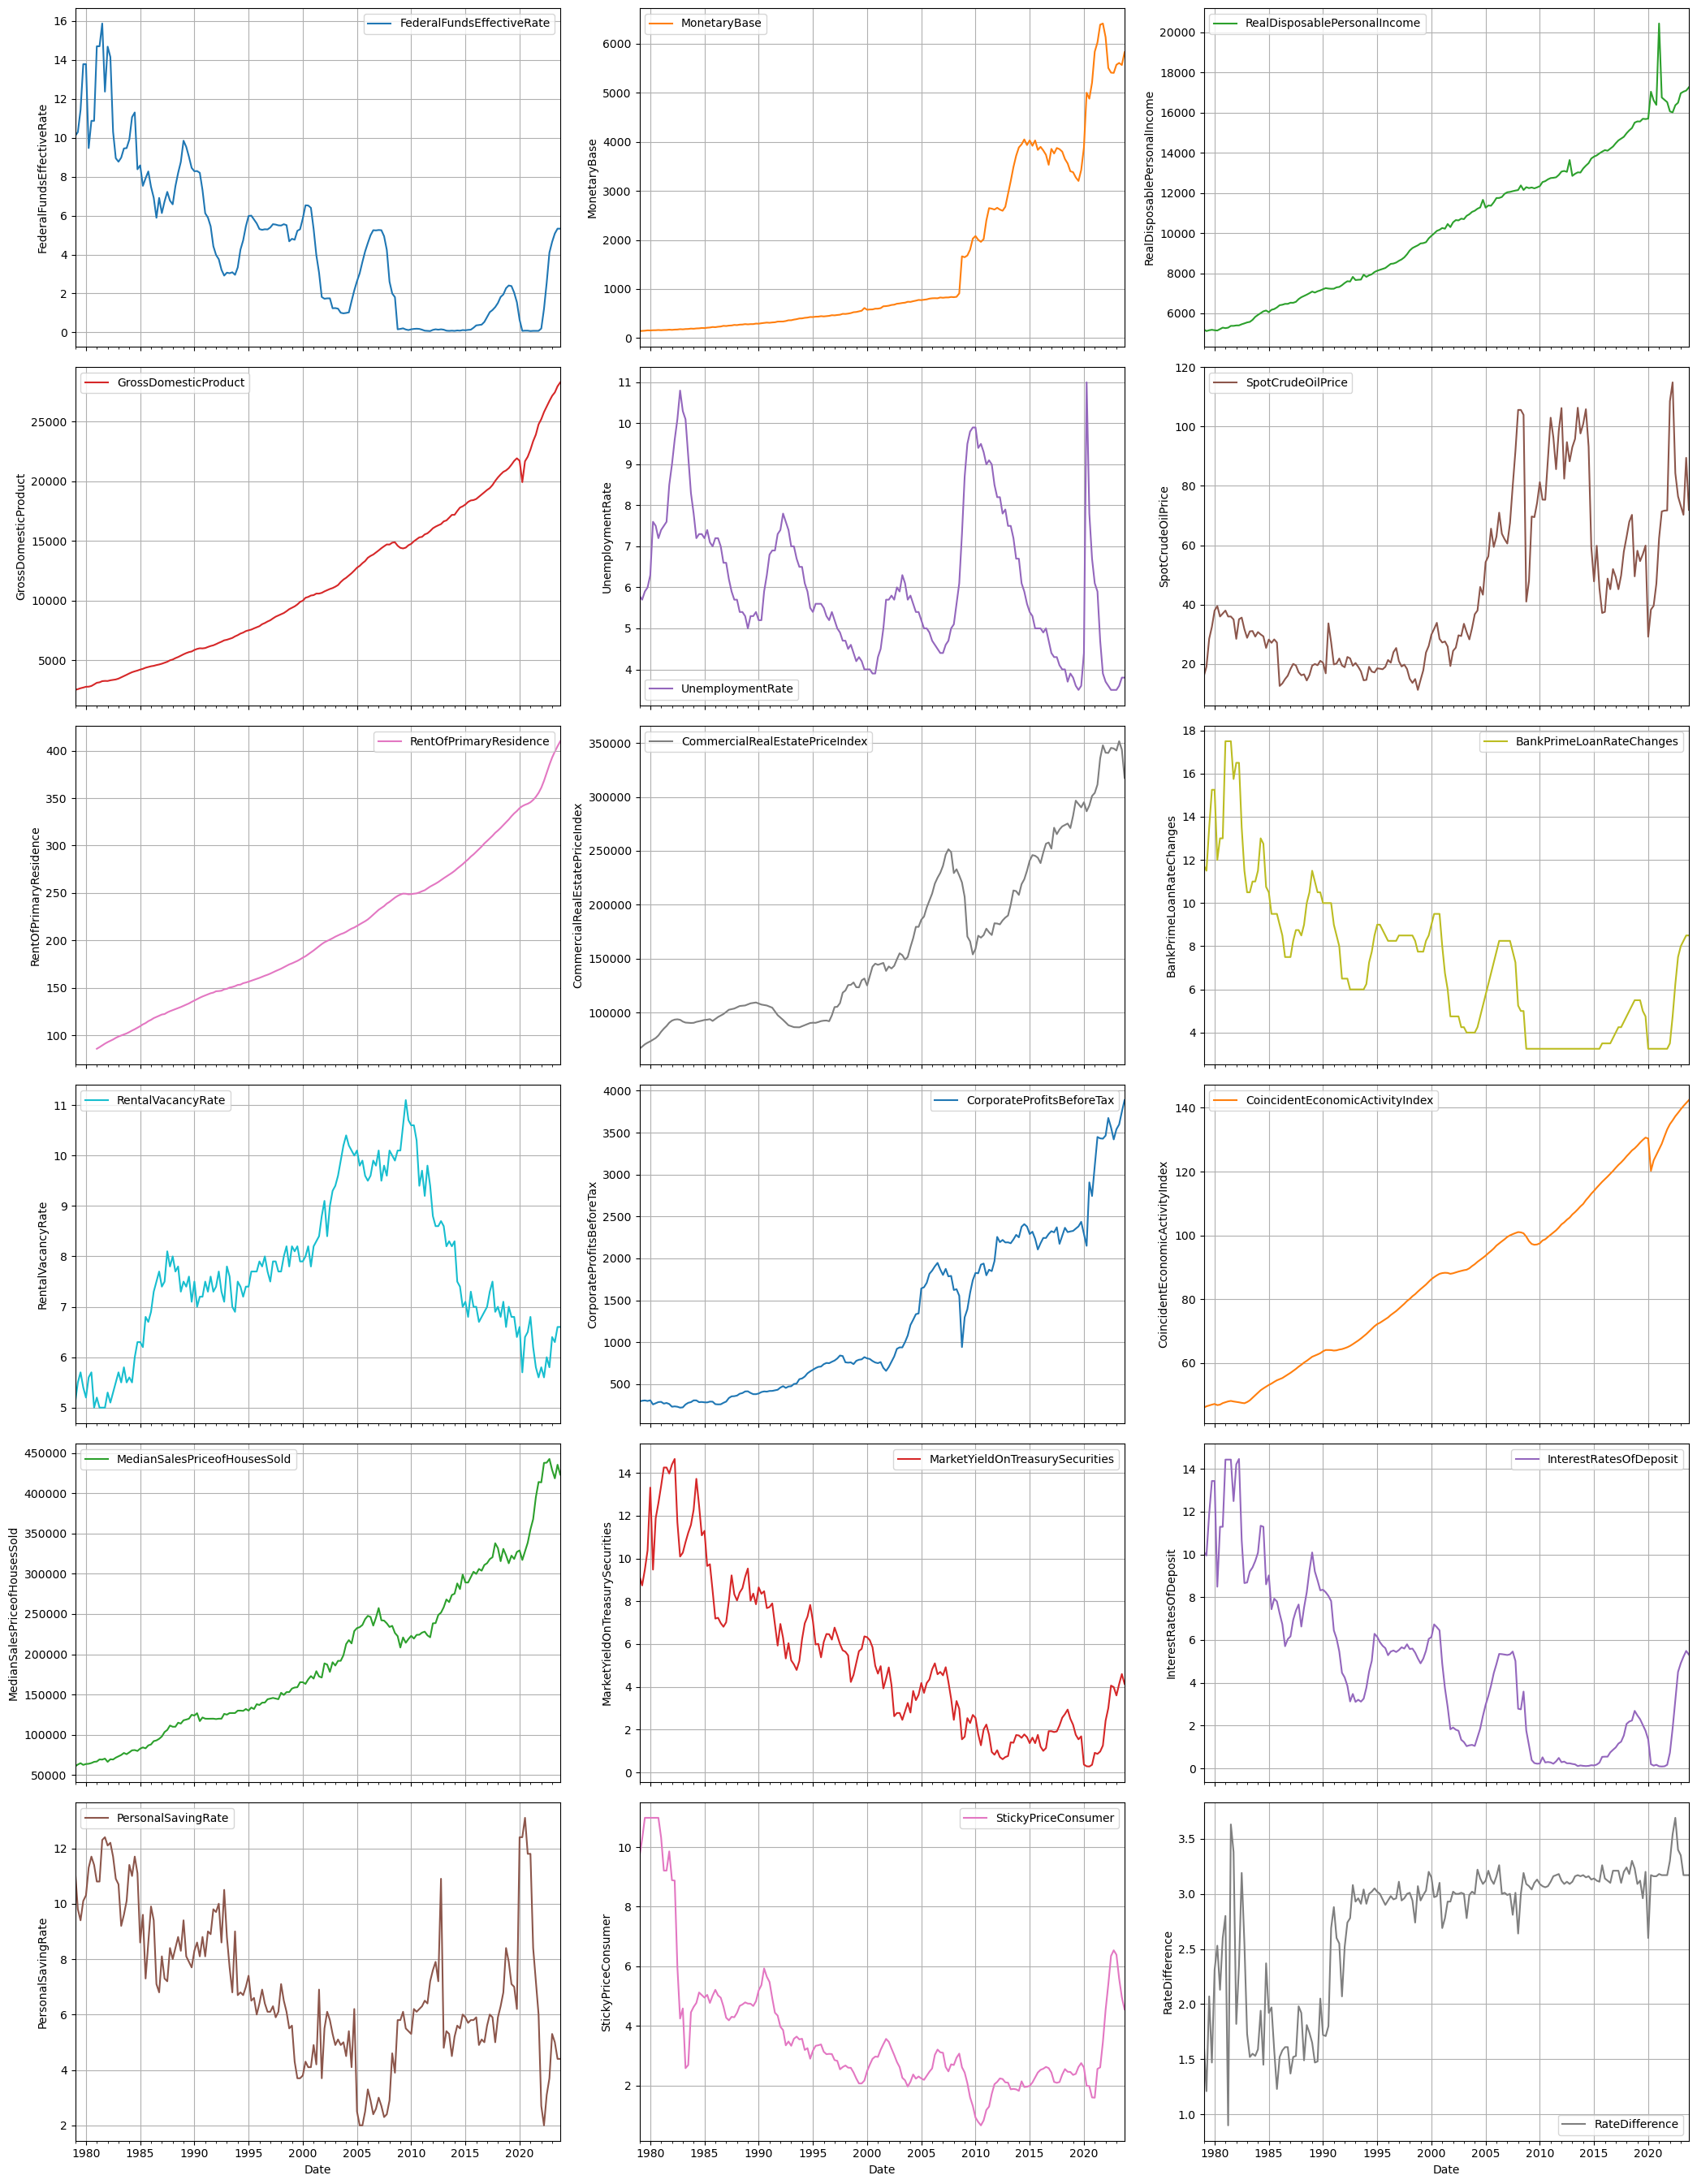

In [33]:
axes = dta[variable_names].plot(subplots=True, layout=(6, 3), figsize=(21, 27))
for i, ax in enumerate(axes.flatten()):
    if i < len(variable_names):
        ax.set_xlabel('Date')
        ax.set_ylabel(variable_names[i])
        ax.grid(True)
plt.tight_layout()
plt.show()

## Нормализация переменных

In [34]:
def normalize(names, df):
    for i in range(len(names)):
        if names[i] in not_diff:
            dln_name_not_diff = 'DLN' + names[i] + 'NotDiff'
            df[dln_name_not_diff] = (np.log(df[names[i]])) * 100
            std_name_not_diff = 'STD' + names[i] + 'NotDiff'
            normal_names.append('STD' + names[i] + 'NotDiff')
            df[std_name_not_diff] = (df[dln_name_not_diff] - df[dln_name_not_diff].mean()) / df[dln_name_not_diff].std()
        dln_name = 'DLN' + names[i]
        df[dln_name] = (np.log(df[names[i]])).diff() * 100
        std_name = 'STD' + names[i]
        if names[i] != 'BankCredit' and names[i] != 'Deposits' and names[i] != 'RealEstateLoans':
            normal_names.append('STD' + names[i])
        df[std_name] = (df[dln_name] - df[dln_name].mean()) / df[dln_name].std()
    return df

Проводим нормализацию «по окнам» ввиду изменения экономической ситуации: 1979 − 1994, 1995 − 2009, 2009 − 2024 годы

In [35]:
normal_names = []
dta79_95 = dta[(dta.index > '1979-01-01') & (dta.index <= '1995-01-01')]
dta79_95 = normalize(names, dta79_95)

dta95_10 = dta[(dta.index >= '1995-01-01') & (dta.index <= '2010-01-01')]
dta95_10 = normalize(names, dta95_10)

dta10_24 = dta[(dta.index >= '2010-01-01') & (dta.index <= '2024-01-01')]
dta10_24 = normalize(names, dta10_24)

dta = pd.concat([dta79_95, dta95_10, dta10_24], axis=0)
dta = dta.dropna()
dta = dta.drop_duplicates()
normal_names = list(set(normal_names))
normal_names.sort()
dta.sample()

BankCredit   Deposits  RealEstateLoans  FederalFundsEffectiveRate  \
DATE                                                                            
1991-07-01   2724.4248  2462.5211         863.9743                       5.45   

            MonetaryBase  RealDisposablePersonalIncome  GrossDomesticProduct  \
DATE                                                                           
1991-07-01         321.8                        7317.7              6205.937   

            UnemploymentRate  SpotCrudeOilPrice  RentOfPrimaryResidence  ...  \
DATE                                                                     ...   
1991-07-01               6.9             21.857                   144.4  ...   

            DLNPersonalSavingRate  STDPersonalSavingRate  \
DATE                                                       
1991-07-01               -1.11733               -0.05787   

            DLNStickyPriceConsumerNotDiff  STDStickyPriceConsumerNotDiff  \
DATE                                                                       
1991-07-01                     149.146369                      -0.373761   

            DLNStickyPriceConsumer  STDStickyPriceConsumer  \
DATE                                                         
1991-07-01              -10.481886               -0.669089   

            DLNRateDifferenceNotDiff  STDRateDifferenceNotDiff  \
DATE                                                             
1991-07-01                 93.609336                  0.700883   

            DLNRateDifference  STDRateDifference  
DATE                                              
1991-07-01          -1.941809          -0.110043  

[1 rows x 85 columns]

## Визуализация тенденций нормализированных банковских продуктов

In [36]:
x = dta.index
y1 = dta['STDBankCredit'].to_numpy()
y2 = dta['STDDeposits'].to_numpy()
y3 = dta['STDRealEstateLoans'].to_numpy()

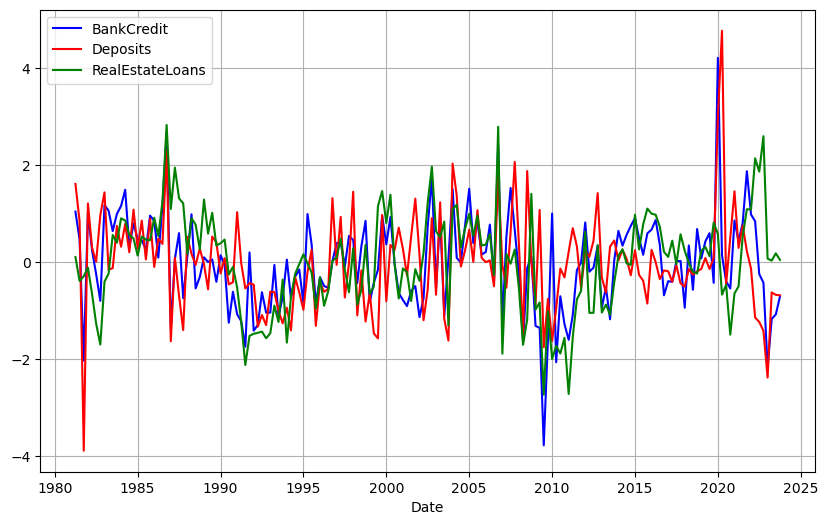

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='BankCredit', color='blue')
plt.plot(x, y2, label='Deposits', color='red')
plt.plot(x, y3, label='RealEstateLoans', color='green')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.show()

## Визуализация тенденций нормализованных макроэкономических переменных

In [38]:
normal_names1 = normal_names[:9]
normal_names2 = normal_names[9:]

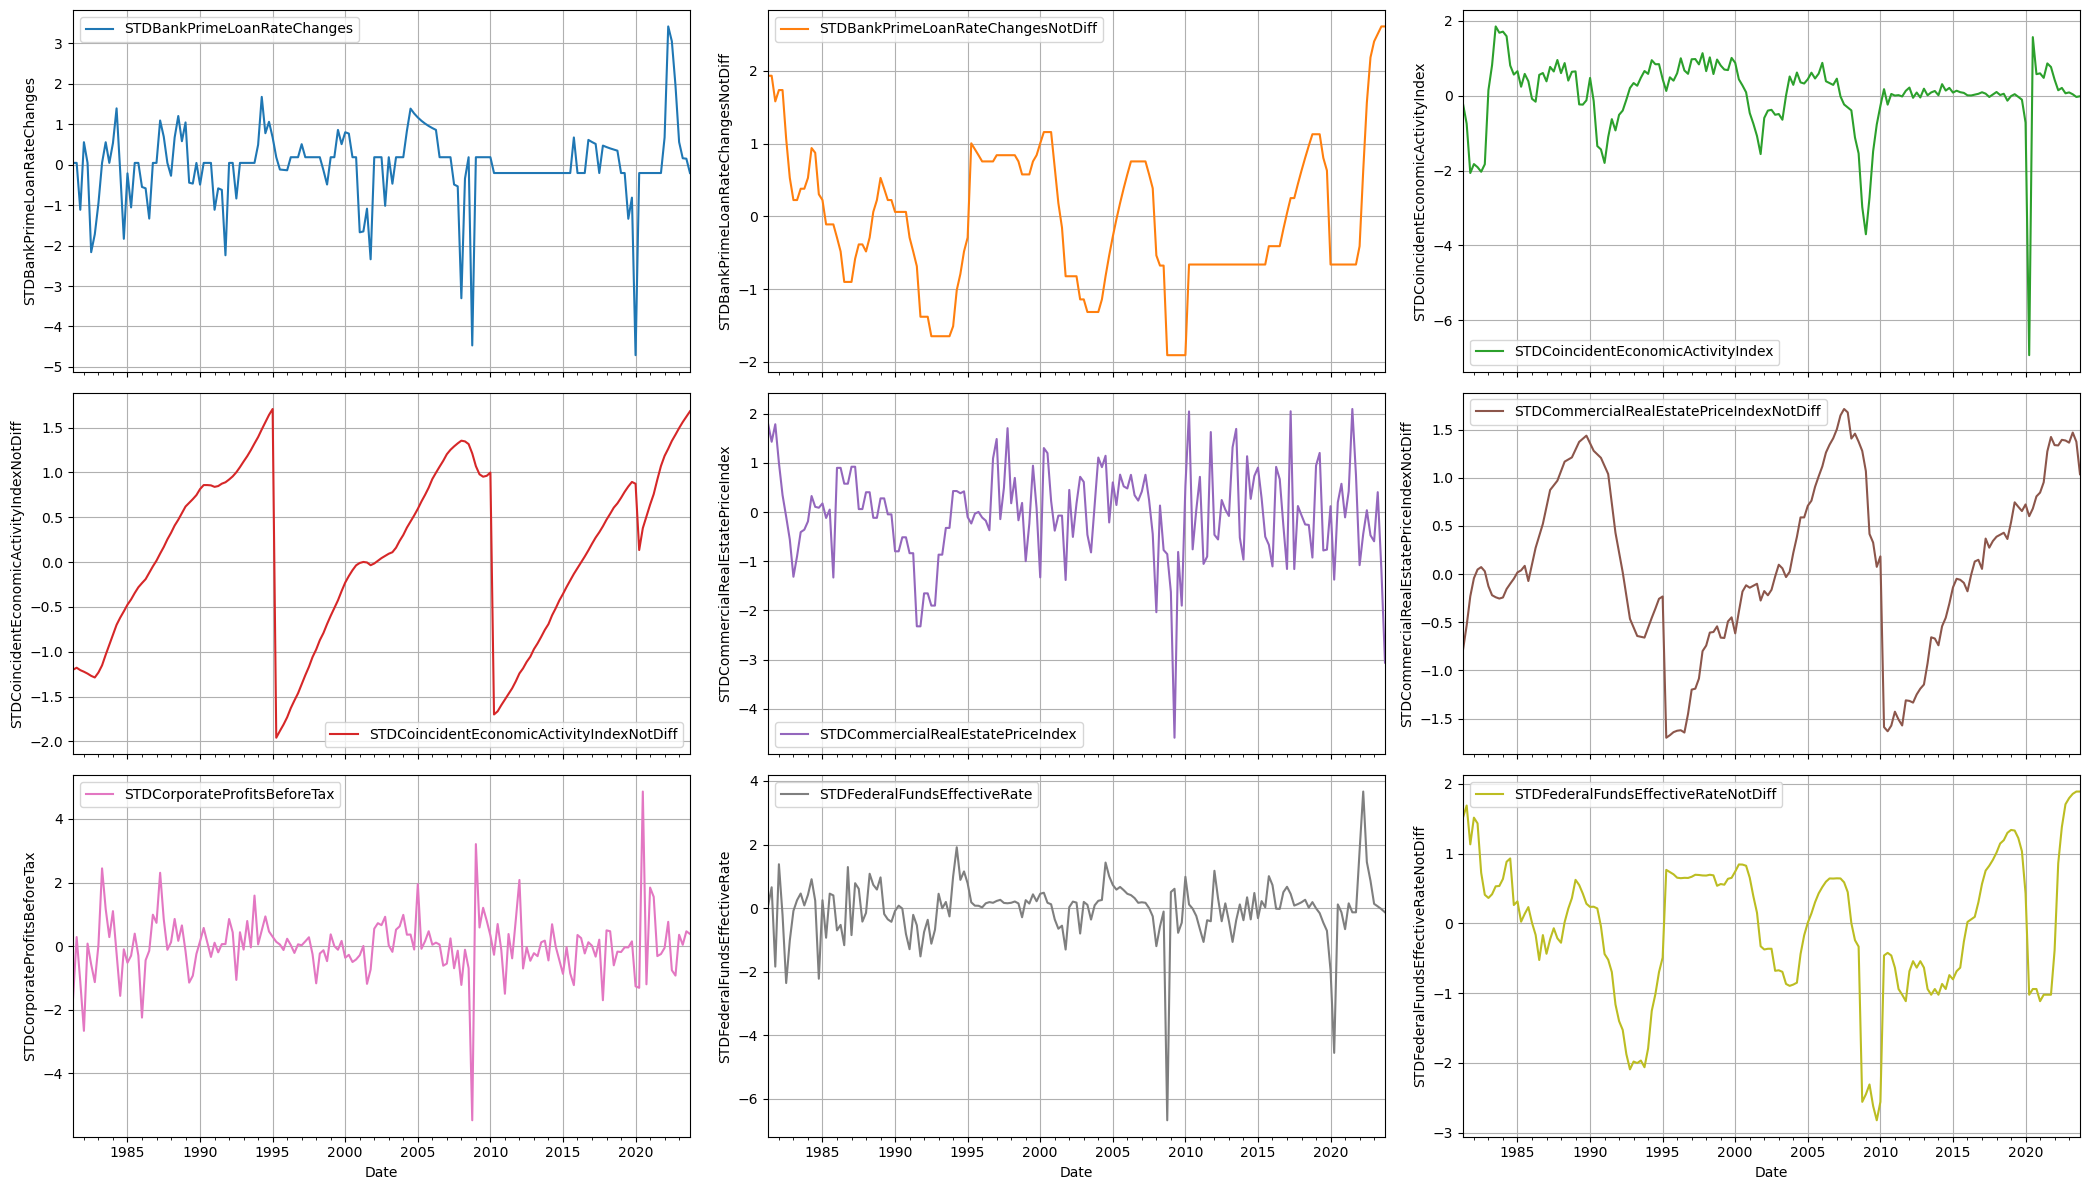

In [39]:
axes = dta[normal_names1].plot(subplots=True, layout=(3, 3), figsize=(21, 12))
for i, ax in enumerate(axes.flatten()):
    if i < len(normal_names1):
        ax.set_xlabel('Date')
        ax.set_ylabel(normal_names1[i])
        ax.grid(True)
plt.tight_layout()
plt.show()

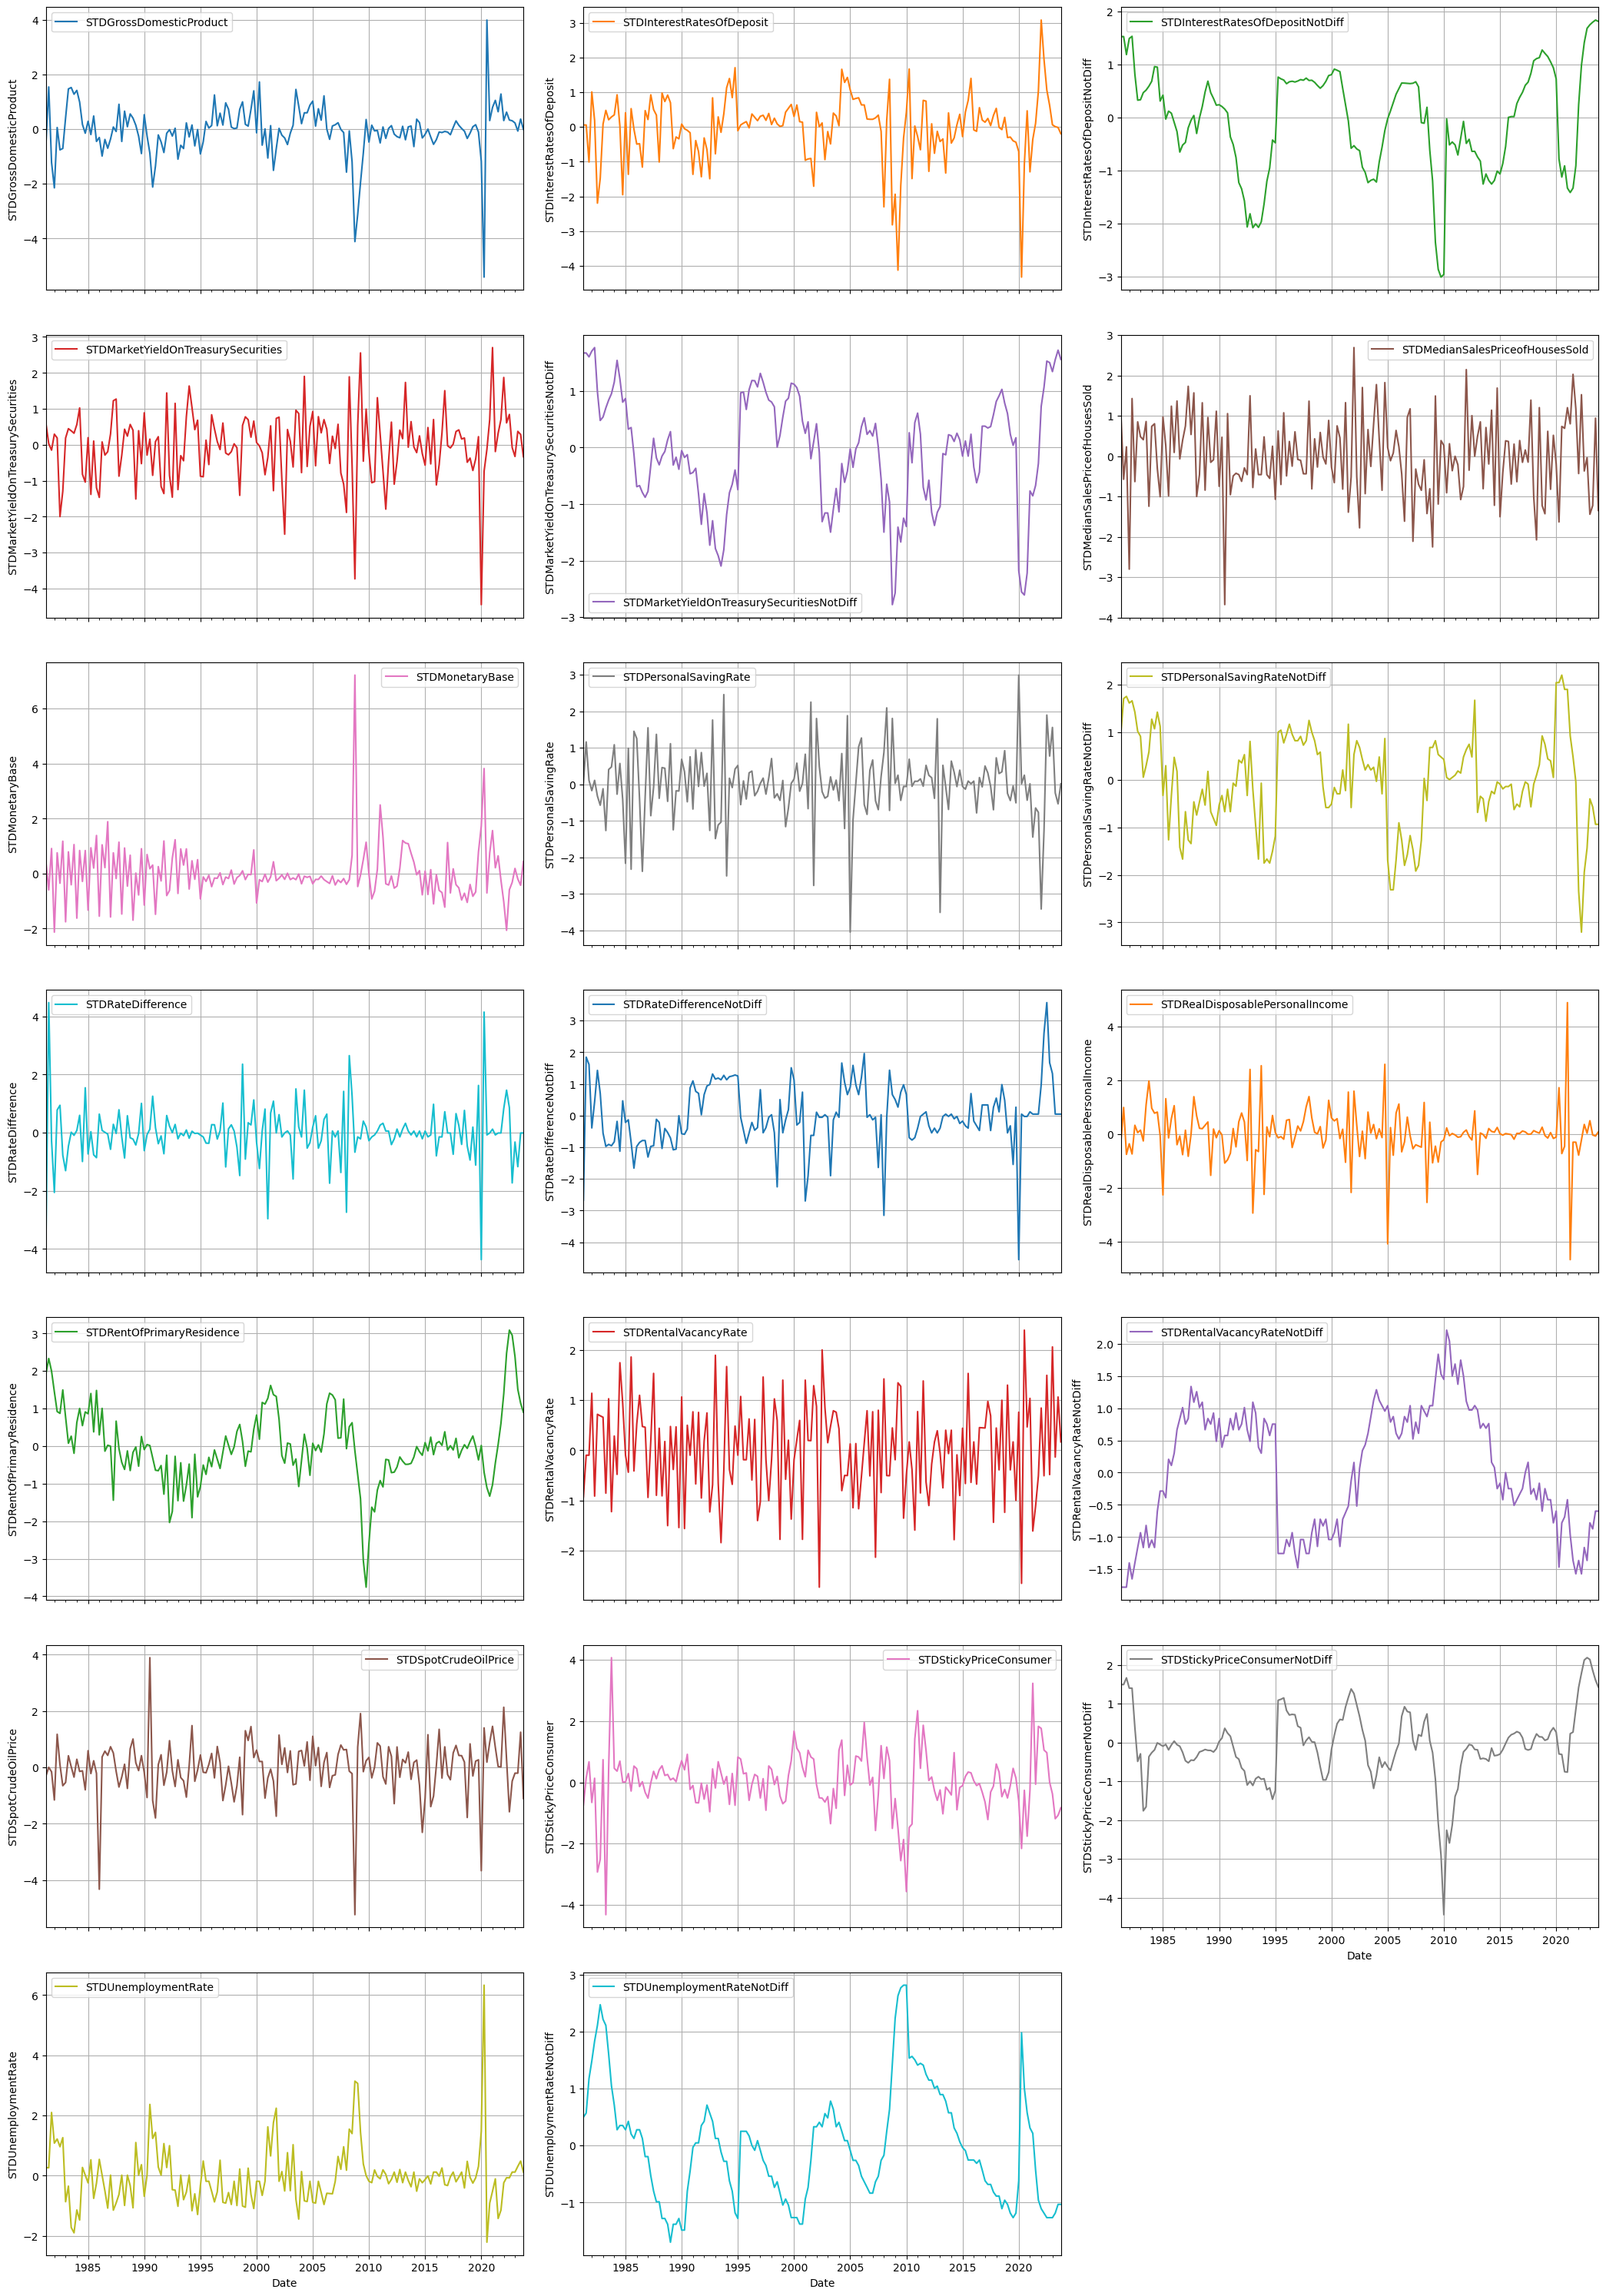

In [40]:
axes = dta[normal_names2].plot(subplots=True, layout=(7, 3), figsize=(21, 30))
for i, ax in enumerate(axes.flatten()):
    if i < len(normal_names2):
        ax.set_xlabel('Date')
        ax.set_ylabel(normal_names2[i])
        ax.grid(True)
plt.tight_layout()
plt.show()

## Корреляции между нормализованными макроэкономическими переменными

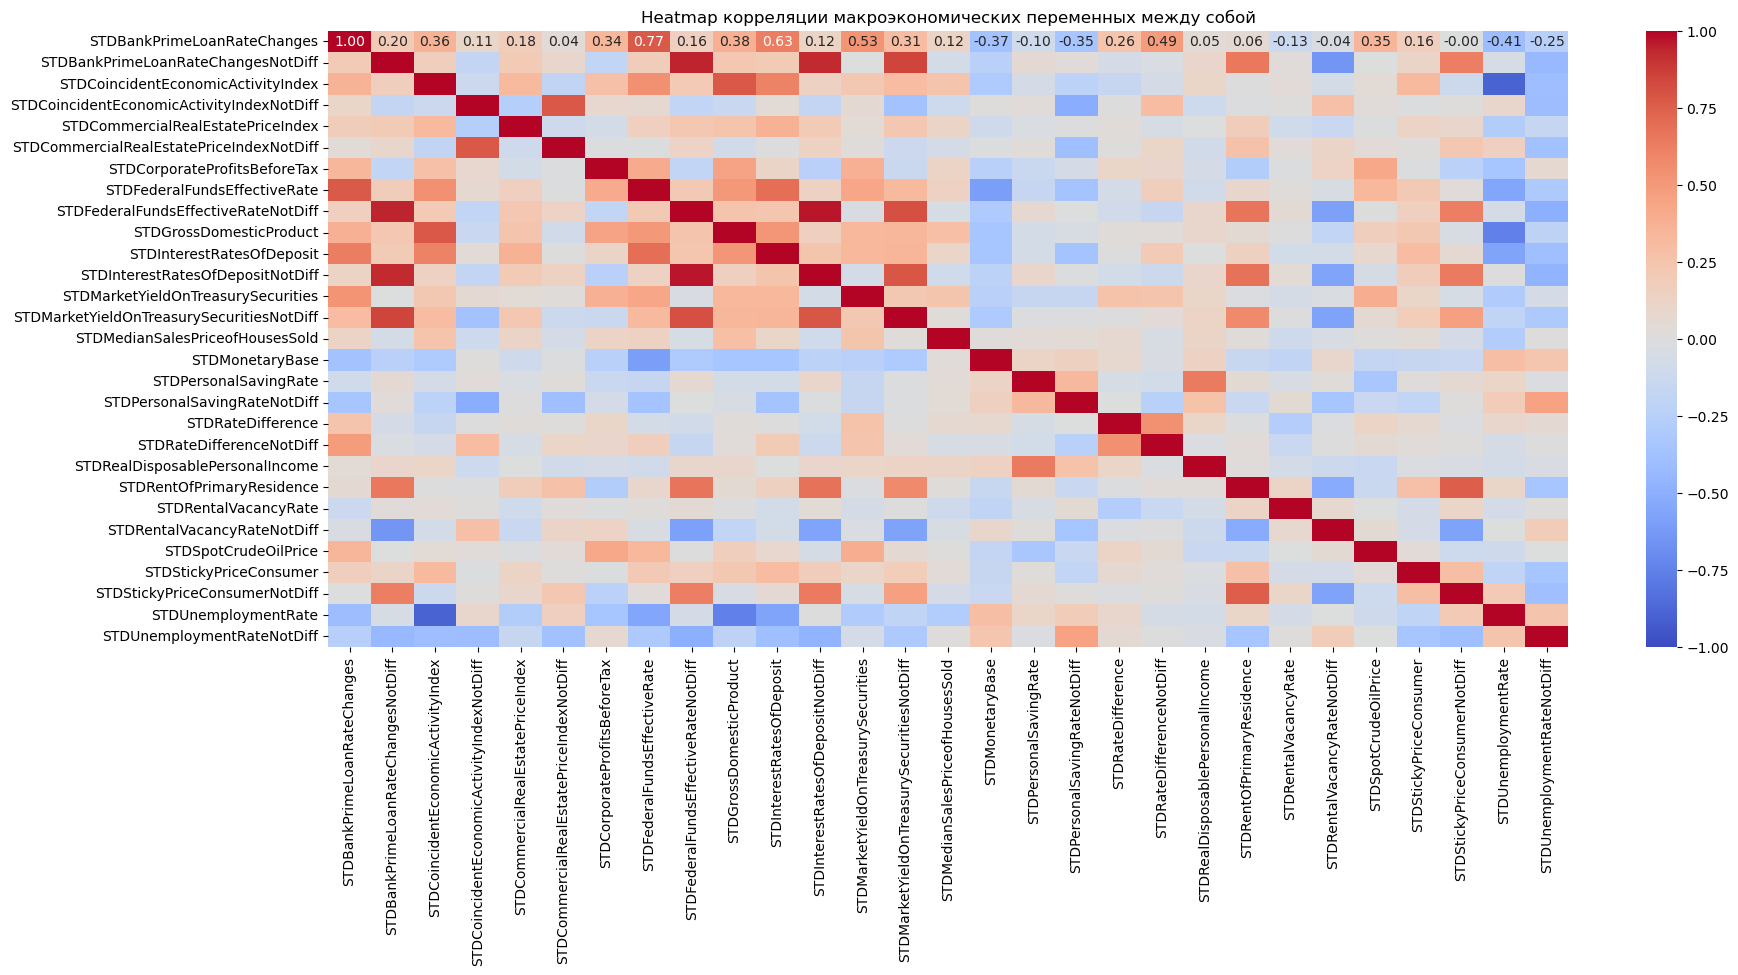

In [41]:
df = dta[normal_names]
plt.figure(figsize=(20, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap корреляции макроэкономических переменных между собой')
plt.show()

## Общая функции для облегчения поиска корреляции

In [42]:
# Функция, которая ищет все корреляции c заданным таргетом
def all_correlation(normal_variable, name):
    answer, variables, normalize_correlation = [], [], []
    for i in range(len(normal_variable)):
        spearman_corr_normalize = pd.Series(dta['STD' + name]).corr(dta[normal_variable[i]], method='spearman')
        answer.append([abs(spearman_corr_normalize), spearman_corr_normalize, normal_variable[i]])
    answer.sort(reverse=True)
    for i in range(len(answer)):
        variables.append(answer[i][2])
        normalize_correlation.append(round(answer[i][1], 4))
    df = pd.DataFrame({
    'Variable': variables,
    'Correlation': normalize_correlation})
    return df

## Поиск корреляций Спирмена для банковских кредитов

In [43]:
def highlight_rows(row, threshold):
    return ['background-color: yellow' if abs(row['Correlation']) > threshold else '' for i in row]

In [44]:
BankCredit_corr = all_correlation(normal_names, 'BankCredit')
BankCredit_corr.style.apply(highlight_rows, threshold=0.22, axis=1)

В данном случае сочтём подходящими переменными те, у которых с банковскими кредитами коэффициент корреляции > 0.22

## Поиск корреляций Спирмена для депозитов

In [45]:
Deposits_corr = all_correlation(normal_names, 'Deposits')
Deposits_corr.style.apply(highlight_rows, threshold=0.16, axis=1)

В данном случае сочтём подходящими переменными те, у которых с депозитами корреляция > 0.16

## Поиск корреляций Спирмена для кредитов на недвижимость

In [46]:
RealEstateLoans_corr = all_correlation(normal_names, 'RealEstateLoans')
RealEstateLoans_corr.style.apply(highlight_rows, threshold=0.27, axis=1)

В данном случае сочтём подходящими переменными те, у которых с кредитами на недвижимость коэффициент корреляции > 0.27

## Сводная таблица всех корреляций между парами «переменная — банковский продукт»

In [47]:
def highlight_rows(row, threshold_BankCredit=0.22, threshold_Deposits=0.16, threshold_RealEstateLoans=0.27):
    styles = [''] * len(row)
    if abs(row['Correlation_BankCredit']) > threshold_BankCredit:
        styles[row.index.get_loc('Correlation_BankCredit')] = 'background-color: yellow'
    if abs(row['Correlation_Deposits']) > threshold_Deposits:
        styles[row.index.get_loc('Correlation_Deposits')] = 'background-color: lightgreen'
    if abs(row['Correlation_RealEstateLoans']) > threshold_RealEstateLoans:
        styles[row.index.get_loc('Correlation_RealEstateLoans')] = 'background-color: lightblue'
    return styles

In [48]:
dfs = [BankCredit_corr, Deposits_corr, RealEstateLoans_corr]
merged_corr = reduce(lambda left, right: pd.merge(left, right, on='Variable', how='outer'), dfs)
merged_corr.columns = ['Variable', 'Correlation_BankCredit', 'Correlation_Deposits', 'Correlation_RealEstateLoans']
styled_merged_corr = merged_corr.style.apply(highlight_rows, axis=1)
html = styled_merged_corr.to_html()
with open('styled_table.html', 'w') as f:
    f.write(html)
styled_merged_corr

## Факторный анализ методом главных компонент переменных, отобранных для предсказания банковских кредитов

In [49]:
columns_to_use = ['STDCoincidentEconomicActivityIndex', 'STDFederalFundsEffectiveRate', 'STDCommercialRealEstatePriceIndex', 'STDRentOfPrimaryResidence', 'STDRentalVacancyRateNotDiff', 'STDInterestRatesOfDeposit', 'STDGrossDomesticProduct']
fa = Factor(dta.loc['1979-01-01':, columns_to_use], n_factor=1, method='pa')
res = fa.fit()
res.get_loadings_frame(threshold=0.3)

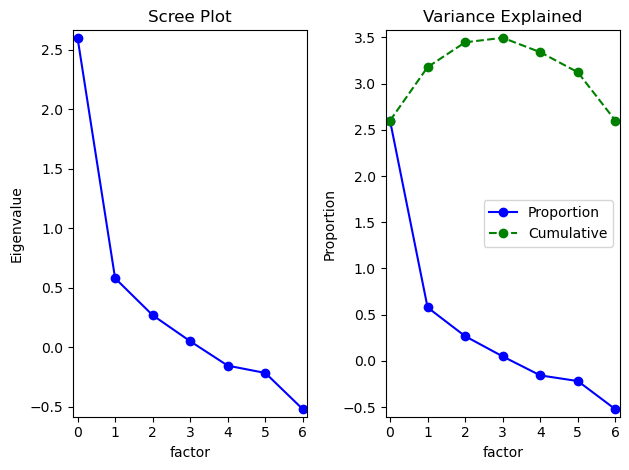

In [50]:
res.plot_scree()
plt.show()

## Факторный анализ методом максимального правдоподобия переменных, отобранных для предсказания банковских кредитов

In [51]:
columns_to_use = ['STDCoincidentEconomicActivityIndex', 'STDFederalFundsEffectiveRate', 'STDCommercialRealEstatePriceIndex', 'STDRentOfPrimaryResidence', 'STDRentalVacancyRateNotDiff', 'STDInterestRatesOfDeposit', 'STDGrossDomesticProduct']
fa = Factor(dta.loc['1979-01-01':, columns_to_use], n_factor=1, method='ml')
res = fa.fit()
res.get_loadings_frame(threshold=0.3)

## Факторный анализ методом главных компонент переменных, отобранных для предсказания депозитов

In [52]:
columns_to_use = ['STDRateDifferenceNotDiff', 'STDBankPrimeLoanRateChanges', 'STDCoincidentEconomicActivityIndexNotDiff', 'STDRentOfPrimaryResidence', 'STDCorporateProfitsBeforeTax', 'STDStickyPriceConsumer', 'STDUnemploymentRateNotDiff']
fa = Factor(dta.loc['1979-01-01':, columns_to_use], n_factor=1, method='pa')
res = fa.fit()
res.get_loadings_frame(threshold=0.3)

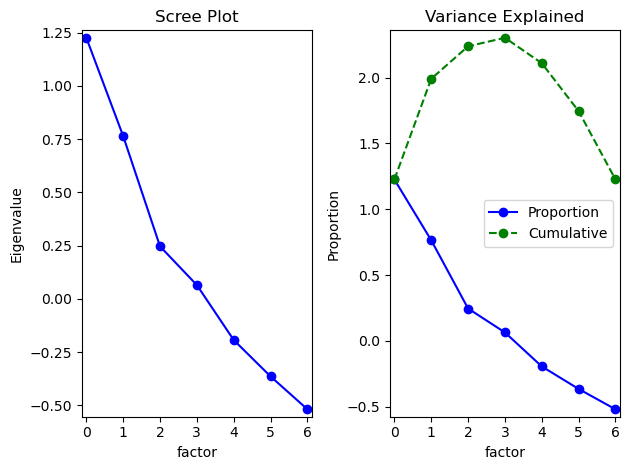

In [53]:
res.plot_scree()
plt.show()

## Факторный анализ методом максимального правдоподобия переменных, отобранных для предсказания депозитов

In [54]:
columns_to_use = ['STDRateDifferenceNotDiff', 'STDBankPrimeLoanRateChanges', 'STDCoincidentEconomicActivityIndexNotDiff', 'STDRentOfPrimaryResidence', 'STDCorporateProfitsBeforeTax', 'STDStickyPriceConsumer', 'STDUnemploymentRateNotDiff']
fa = Factor(dta.loc['1979-01-01':, columns_to_use], n_factor=2, method='ml')
res = fa.fit()
res.get_loadings_frame(threshold=0.3)

## Факторный анализ методом главных компонент переменных, отобранных для предсказания кредитов на недвижимость

In [55]:
columns_to_use = ['STDUnemploymentRateNotDiff', 'STDRentOfPrimaryResidence', 'STDCommercialRealEstatePriceIndexNotDiff', 'STDFederalFundsEffectiveRate', 'STDInterestRatesOfDeposit', 'STDFederalFundsEffectiveRateNotDiff', 'STDPersonalSavingRateNotDiff']
fa = Factor(dta.loc['1972-01-01':, columns_to_use], n_factor=1, method='pa')
res = fa.fit()
res.get_loadings_frame(threshold=0.3)

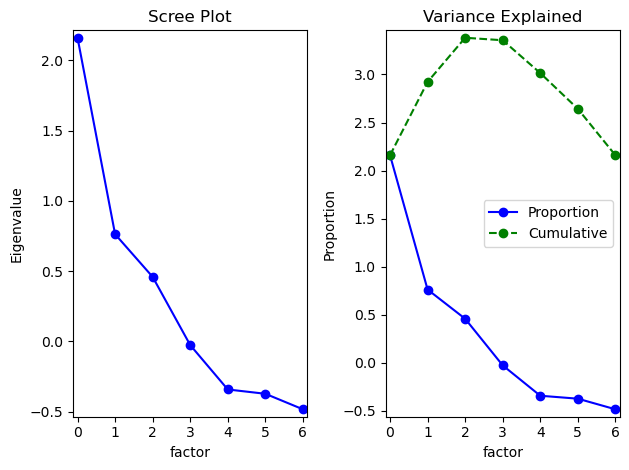

In [56]:
res.plot_scree()
plt.show()

## Факторный анализ методом максимального правдоподобия переменных, отобранных для предсказания кредитов на недвижимость

In [57]:
columns_to_use = ['STDUnemploymentRateNotDiff', 'STDRentOfPrimaryResidence', 'STDCommercialRealEstatePriceIndexNotDiff', 'STDFederalFundsEffectiveRate', 'STDInterestRatesOfDeposit', 'STDFederalFundsEffectiveRateNotDiff', 'STDPersonalSavingRateNotDiff']
fa = Factor(dta.loc['1972-01-01':, columns_to_use], n_factor=1, method='ml')
res = fa.fit()
res.get_loadings_frame(threshold=0.3)

## Первая имплементация DFM для кредитов на недвижимость

In [58]:
columns_to_use = ['STDUnemploymentRateNotDiff', 'STDRentOfPrimaryResidence', 'STDCommercialRealEstatePriceIndexNotDiff', 'STDFederalFundsEffectiveRate', 'STDInterestRatesOfDeposit', 'STDFederalFundsEffectiveRateNotDiff', 'STDPersonalSavingRateNotDiff']
endog = dta.loc['1979-04-01':, columns_to_use]
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=2, error_order=2)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)
print(res.summary(separate_params=False))

                                                                                                                                        Statespace Model Results                                                                                                                                       
Dep. Variable:     ['STDUnemploymentRateNotDiff', 'STDRentOfPrimaryResidence', 'STDCommercialRealEstatePriceIndexNotDiff', 'STDFederalFundsEffectiveRate', 'STDInterestRatesOfDeposit', 'STDFederalFundsEffectiveRateNotDiff', 'STDPersonalSavingRateNotDiff']   No. Observations:                  171
Model:                                                                                                                                                                                                                       DynamicFactor(factors=1, order=2)   Log Likelihood                -754.643
                                                                                                                

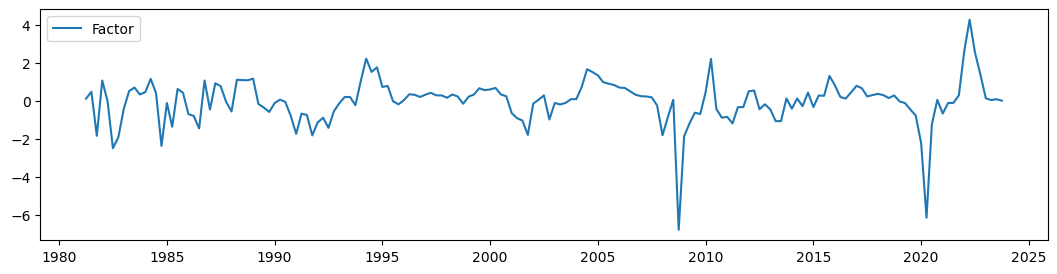

In [59]:
fig, ax = plt.subplots(figsize=(13,3))
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()
plt.show()

## Сравнени полученного Factor и нормализированного RealEstateLoans

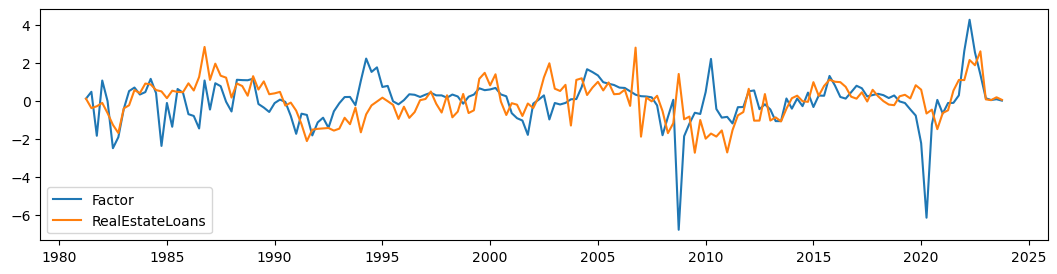

In [60]:
fig, ax = plt.subplots(figsize=(13,3))
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.plot(dates, dta.loc['1979-04-01':, ['STDRealEstateLoans']], label='RealEstateLoans')
ax.legend()
plt.show()

## Просмотр подобранных коэффициентов

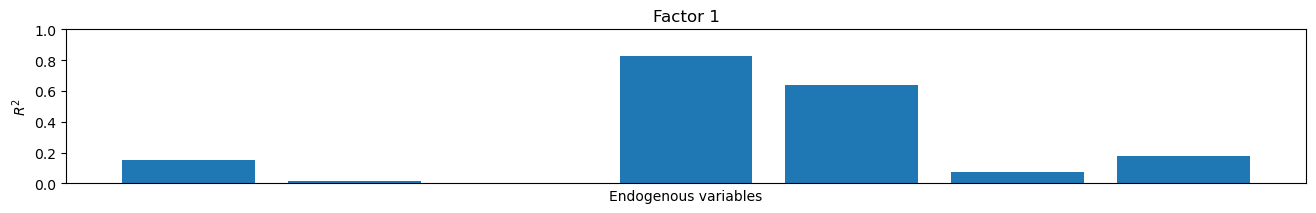

In [61]:
res.plot_coefficients_of_determination(figsize=(16,2));